In [1]:
import torch
import torch.nn as nn

import math
import torch.autograd as autograd


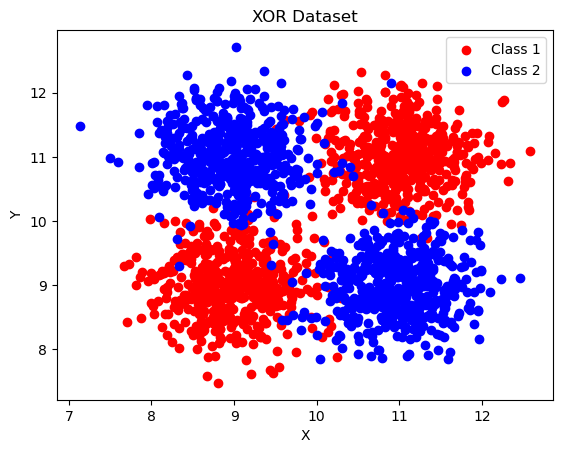

In [2]:

# Enable anomaly detection
autograd.set_detect_anomaly(True)

import numpy as np
import matplotlib.pyplot as plt

# Generate the dataset
np.random.seed(0)

# Generate class 1 points (top left and bottom right)
class1 = np.random.normal(loc=[-1, -1], scale=0.5, size=(500, 2))
class1 = np.concatenate((class1, np.random.normal(loc=[1, 1], scale=0.5, size=(500, 2))))

# Generate class 2 points (top right and bottom left)
class2 = np.random.normal(loc=[1, -1], scale=0.5, size=(500, 2))
class2 = np.concatenate((class2, np.random.normal(loc=[-1, 1], scale=0.5, size=(500, 2))))


# add 2,2 to x,y of points in class 1 and 2
class1 = class1 + 10
class2 = class2 + 10

# Combine class 1 and class 2 points
X = np.concatenate((class1, class2))
y = np.concatenate((np.zeros(1000), np.ones(1000) ))

# Plot the dataset
plt.scatter(class1[:, 0], class1[:, 1], c='red', label='Class 1')
plt.scatter(class2[:, 0], class2[:, 1], c='blue', label='Class 2')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('XOR Dataset')
plt.legend()
plt.show()



In [3]:
# convert the numpy arrays to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

In [4]:
# shuffle the data
shuffle_idx = torch.randperm(len(X))
X = X[shuffle_idx]
y = y[shuffle_idx]
y

tensor([0, 1, 0,  ..., 0, 0, 1])

In [5]:
X

tensor([[ 8.2775,  8.3947],
        [ 8.3123, 11.3115],
        [10.7340, 10.5219],
        ...,
        [ 8.7682,  9.2407],
        [ 9.0226, 10.1698],
        [11.1712,  8.8883]])

In [38]:
class QuasiPolySynapse(nn.Module):
    def __init__(self):
        super().__init__() 
        self.main = nn.Parameter(torch.randn(1))
        self.terms = nn.ParameterList()

        
    def forward(self, x):
        # if  len(self.terms) < math.floor(self.main[1]) - 1:
        #     self.add_term()
        y = self.main[0] * x
        for idx,coeff in enumerate(self.terms):
             y = y + coeff * x**(idx+1)
        return y

    def add_term(self):
        print("Adding term")
        # Add new term, init coeff to 1. non-trainable exponent to floor of main exponent
        self.terms.append(nn.Parameter(torch.tensor([1.])))

    def __str__(self):
        s = ""
        s += f"Main: {self.main[0]} "
        for idx,term in enumerate(self.terms):
            s += f"{term}x^{idx+1} + "
        return s[:-3]



class Network2(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.out_features = out_features
    self.in_features = in_features
    # a 2d module list of quasipoly synapses sizes in_features x out_features
    self.synapses = nn.ModuleList([nn.ModuleList([QuasiPolySynapse() for _ in range(self.in_features)]) for _ in range(self.out_features)])
    self.bias = nn.Parameter(torch.randn(out_features))
  
  def forward(self, x): # x is a batch of inputs

    y = torch.zeros(x.shape[0], self.out_features, dtype=torch.float32)
    # print(f"synapses shape {len(self.synapses)} {len(self.synapses[0])}")
    
    # apply synapses to inputs
    for i in range(self.out_features):
      for j in range(self.in_features):
        # print(f"synapse {i} {j} {self.synapses[i][j]}")
        y[:, i] = y[:, i] + self.synapses[i][j](x[:, j])

    # add bias
    y = y + self.bias
    

    # print synapses and bias
    # for i in range(len(self.synapses)):
    #   for j in range(len(self.synapses[i])):
    #     print(f"synapse {i} {j} {self.synapses[i][j]}")
    # print(f"bias {self.bias}")
        
    # sum the outputs of the synapses
    # y = y.sum(dim=1)
        
    # y = y.squeeze()
    
    # print(f"y shape after loops {y.shape}")

    # print(f"y before relu {y[:5]}")
    
    # y = nn.functional.relu(y)

    # print(f"y after relu {y}")
    y = nn.functional.softmax(y, dim=1)

    # print(f"y after softmax {y}")
    # print(f"x.shape after sum {y.shape}")


    return y
  

model = Network2(2, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)



In [39]:

num_samples = X.shape[0]

# Train the model

EPOCH_COUNT = 100
BATCH_SIZE = 100

for epoch in range(EPOCH_COUNT):
    for i in range(0, num_samples, BATCH_SIZE):
        # Get the batch
        batch_X = X[i:i+BATCH_SIZE]
        batch_y = y[i:i+BATCH_SIZE]

        # Forward pass
        outputs = model(batch_X)
        
        loss = criterion(outputs, batch_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print gradients
        # for name, param in model.named_parameters():
        #     print(f"name {name} param.grad {param.grad}")

    # print loss and accuracy
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == batch_y).sum().item()
    accuracy = correct / BATCH_SIZE
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}")


Epoch 1, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 2, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 3, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 4, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 5, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 6, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 7, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 8, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 9, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 10, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 11, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 12, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 13, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 14, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 15, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 16, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 17, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 18, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 19, Loss: 0.8832618594169617, Accuracy: 0.43
Epoch 20, Loss: 0.8832618594169617, Accu

In [ ]:

# calculate the accuracy of model by trying all possible inputs
with torch.no_grad():
    outputs = model(X)
    loss = criterion(outputs, y)
    # compare the predicted output with the actual output one by one
    print(f"outputs shape: {outputs.shape}")
    for i in range(4):
        print(f"Predicted: {outputs[i].item()}, Actual: {y[i].item()}")
    
    # print(loss)

synapse 0 0 Main: 1.0x^1.0
synapse 0 1 Main: 1.0x^1.0
synapse 1 0 Main: 1.0x^1.0
synapse 1 1 Main: 1.0x^1.0
y after relu tensor([[20.3623, 20.3623],
        [18.0611, 18.0611],
        [19.6198, 19.6198],
        ...,
        [18.5071, 18.5071],
        [21.1760, 21.1760],
        [17.1355, 17.1355]])
y after softmax tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        ...,
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]])
outputs shape: torch.Size([2000, 2])


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar